In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 2. ЗАВДАННЯ ДО ЛАБОРАТОРНОЇ РОБОТИ

In [104]:
class Interpolation:
    def __init__(self, type:str ="image", *args):
        if type == "image":
            self.image = Image.open(args[0])
        elif type == "function":
            self.function = args[0]
        
    def linear_interpolation(self, **kwargs):
        my_image = np.asarray(self.image)
        m, n, k = my_image.shape
        
        my_image_new = np.zeros((2*m-1, 2*n-1, k))
        
        my_image_new[:2*m-1:2, :2*n-1:2, :] = my_image
        my_image_new[1:2*m-1:2, :2*n-1:2, :] = 0.5 * (my_image_new[:2*m-3:2, :2*n-1:2, :] + my_image_new[2:2*m-1:2, :2*n-1:2, :]) # Down
        my_image_new[:2*m-1:2, 1:2*n-1:2, :] = 0.5 * (my_image_new[:2*m-1:2, :2*n-3:2, :] + my_image_new[:2*m-1:2, 2:2*n-1:2, :]) # Right
        my_image_new[1:2*m-1:2, 1:2*n-1:2, :] = 0.5 * (my_image_new[:2*m-3:2, :2*n-2:2, :] + my_image_new[2:2*m-1:2, :2*n-2:2, :]) # Middle
        
        self.image_modified = np.uint8(my_image_new)
        
        if "save" in kwargs and kwargs["save"] == True:
            if "path" in kwargs:
                Image.fromarray(self.image_modified).save(kwargs["path"])
            else:
                Image.fromarray(self.image_modified).save("lab5/out/1.jpg")
        if "show" in kwargs and kwargs["show"] == True:
            plt.imshow(Image.fromarray(self.image_modified))
            plt.show()
        if "show_in_window" in kwargs and kwargs["show_in_window"] == True:
            Image.fromarray(self.image_modified).show()
        if "replace" in kwargs and kwargs["replace"] == True:
            self.image = self.image_modified
        if "rvalue" in kwargs and kwargs["rvalue"] == True:
            return self.image_modified
        
        return self

    def polynomial_interpolation(self):
        nx = self.image.size[0]
        ny = self.image.size[1]
        my_image = np.array(self.image)
        my_image_new = np.zeros_like(my_image)
        kx = 1
        for Lx in range(1, nx):
            xx = []
            for i in range(1, N_step_polinom+1):
                xx = [xx, X[kx]]
                kx = kx + 1

            kx = kx - 1
            ky = 1
            for Ly in range(1, ny):
                yy = []
                for j in range(1, N_step_polinom+1):
                    yy = [yy, Y[ky]]
                    ky = ky + 1
                ky = ky - 1
                sol = build_system(xx,yy)
                for i1 in range(xx[1], xx(N_step_polinom+1)):
                    for j1 in range(yy[1], yy(N_step_polinom+1)):
                        my_image_new[i1, j1,:] = polinom_summ(sol, (i1-xx[1]+1)/xx[end], (j1-yy[1]+1)/yy[end])
        self.image_modified = Image.fromarray(my_image_new)
        self.image_modified.show()

    def furies_interpolation(self):
        my_image = np.array(self.image)
        my_image_new = np.zeros_like(my_image)
        
        nx = 30
        ny = 30
        x = np.arange(1, nx)
        y = np.arange(1, ny)
        put_x_pixel = 3
        put_y_pixel = 3
        for i in range(1, nx):
            X[i] = i+(i-1)*put_x_pixel
            for j in range(1, ny):
                Y[j] = j+(j-1)*put_y_pixel
                my_image[i,j] = np.sin(x[i]/nx*np.pi)*np.cos(2*y[j]/ny*np.pi)+1

        [Y,X] = np.meshgrid(Y,X)
        
        nx_new = nx+(nx-1)*put_x_pixel
        ny_new = ny+(ny-1)*put_y_pixel
        
        x_new = np.arange(1, nx_new)
        y_new = np.arange(1, ny_new)
        
        [y_new,x_new] = np.meshgrid(y_new,x_new)
        
        my_image_new = resample(my_image, put_x_pixel+1, 1)
        my_image_new = resample(my_image_new, put_y_pixel+1, 1)

        surf(x_new, y_new, my_image_new[1:nx_new,1:ny_new])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(X,Y,my_image,'*m')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        plt.show()
    
    def least_squares_interpolation(self):
        # my_image = np.array(self.image)
        # my_image_new = np.zeros_like(my_image)
        
        # N = 20
        # x = np.linspace(N, 1)
        
        # a = 2.1
        # b = -7.5
        # c = 10
        
        # y = a*x**2 + b*x + c + np.linspace(N, 1)
        
        # A = np.array([x ** 2, x, np.ones((N, 1))])
        # b = y
        # b = A.T*b
        # A = A.T*A
        # sol = A/b
        # X = sort(x)
        # Y_model = sol[1] * X ** 2 + sol[2] * X + sol[3]
        # plt.plot(x, y, ".")
        # plt.plot(X, Y_model, ".") 
        
        nx = 10 # кількість базових вузлів сітки по осі ОХ
        ny = 10 # кількість базових вузлів сітки по осі ОУ
        N_step_polinom = 4 # максимальна степінь (вище не застосовують)
        Nx = nx * N_step_polinom+1
        Ny = ny * N_step_polinom+1
        x = np.arange(1, nx)
        y = np.arange(1, ny)
        put_x_pixel = 3 # кількість пікселів, які необхідно вставити вздовж осі абсцис (більше не використовують)
        put_y_pixel = 3 # кількість пікселів, які необхідно вставити вздовж осі ординат (більше не використовують)
        for i in range(1, Nx):
            for j in range(1, Ny):
                my_image[i,j] = np.sin(x[i]/Nx*np.pi)*np.cos(2*y[j]/Ny*np.pi)+2

        nx_new = Nx+(Nx-1)*put_x_pixel
        ny_new = Ny+(Ny-1)*put_y_pixel

        x_new = np.arange(1, nx_new)
        y_new = np.arange(1, ny_new)

        my_image_new = np.zeros(nx_new,ny_new)
        
        for i in range(1, Nx):
            X[i] = i+(i-1)*put_x_pixel
            for j in range(1, Ny):
                Y[j] = j+(j-1)*put_y_pixel
                my_image_new[X(i), Y(j)] = my_image(i,j)
        kx = 1
        for Lx in range(1, nx):
            xx = []
            for i in range(1, N_step_polinom+1):
                xx = [xx, X[kx]]
                kx = kx + 1
            kx = kx - 1
            ky = 1
            for Ly in range(1, ny):
                yy = []
                for j in range(1, N_step_polinom+1):
                    yy = [yy, Y[ky]]
                    ky = ky + 1
                ky = ky - 1
                sol = build_system(xx,yy)
                for i1 in range(xx[1], xx[N_step_polinom+1]):
                    for j1 in range(yy[1], yy[N_step_polinom+1]):
                        my_image_new[i1, j1] = polinom_summ(sol,(i1-xx[1]+1)/xx[end],(j1-yy(1)+1)/yy[end])
        mesh(x_new, y_new, my_image_new)
        for i in range(1, Nx):
            for j in range(1, Ny):
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')

                ax.plot(X[i], Y[j],my_image[i,j],'m*')
                
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                
                plt.show()
        size(my_image_new)

    def show(self):
        plt.imshow(Image.fromarray(self.image_modified))
        plt.show()

### 3. Після вивчення математичних методів програмно реалізувати інтерполювання функції (обрати самостійно) виду z = f(x, y) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур’є, інтерполювання з використанням методу найменших квадратів. Продемонструвати отримані результати.

### 5. Програмно реалізувати інтерполювання зображення (взяти маленьке зображення і порівняно велике зображення) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур’є, інтерполювання з використанням методу найменших квадратів. Продемонструвати отримані результати. Визначити переваги і недоліки кожного з реалізованих методів.

In [105]:
image = Interpolation("image", "lab5/Test1.jpg")
image.least_squares_interpolation()

NameError: name 'my_image' is not defined

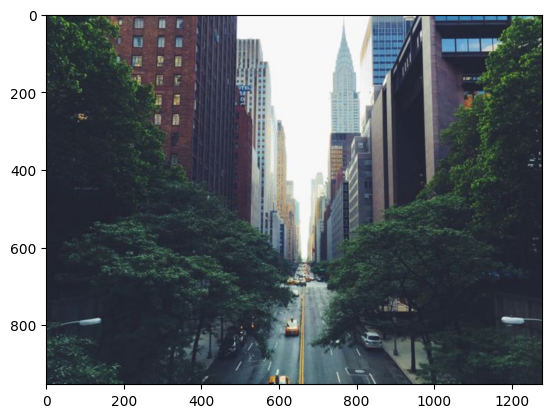

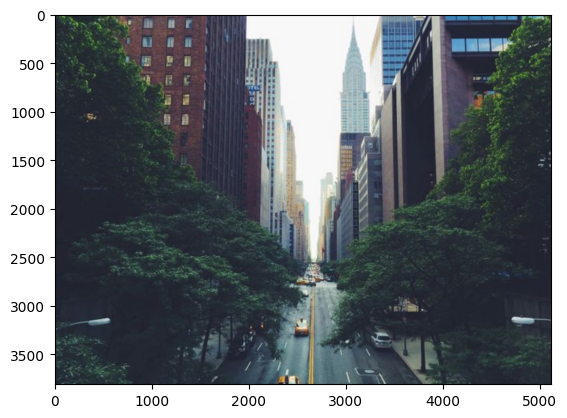

In [106]:
image = Interpolation("image", "lab5/Test1.jpg")
image.linear_interpolation().show()
image.linear_interpolation(replace=True).linear_interpolation(replace=True).linear_interpolation(show=True)